### ReAct Agent architecture

- Act --> The model calls specific tools
- Observe --> Passes the tools output back to the models
- Reason --> Based on the output response from the tool, the model will decide what to do in the next step

After the tool is called, we won't end the conversation. It will continue to call LLM and reason based on the output.


In [3]:
from dotenv import load_dotenv
import os

load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = os.getenv("LANGSMITH_TRACING")
os.environ["LANGSMITH_PROJECT"] = os.getenv("LANGSMITH_PROJECT")
os.environ["LANGSMITH_ENDPOINT"] = os.getenv("LANGSMITH_ENDPOINT")

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

In [4]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun, TavilySearchResults
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max = 1000)
arxiv_tool = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)

api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max = 1000)
wiki_tool = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)

tavily_tool = TavilySearchResults()

/var/folders/d_/nlpw_2qx69j3vzw0s5vj48p80000gn/T/ipykernel_27321/4231601356.py:10: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults()


In [5]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b
    Args:
        a: int
        b: int
    Returns:
        int: The product of a and b
    """
    return a * b

def add(a: int, b: int) -> int:
    """Add a and b
    Args:
        a: int
        b: int
    Returns:
        int: The sum of a and b
    """
    return a + b

def subtract(a: int, b: int) -> int:
    """Subtract b from a
    Args:
        a: int
        b: int
    Returns:
        int: The difference between a and b
    """
    return a - b

def divide(a: int, b: int) -> int:
    """Divide a by b
    Args:
        a: int
        b: int
    Returns:
        int: The quotient of a and b
    """
    return a / b

In [9]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
tools = [multiply, add, subtract, divide, arxiv_tool, wiki_tool, tavily_tool]
llm_with_tools = llm.bind_tools(tools)

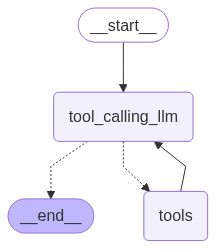

In [12]:
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

class State(TypedDict):
    messages: Annotated[list[dict], add_messages]

def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph = StateGraph(State)
graph.add_node("tool_calling_llm", tool_calling_llm)
graph.add_node("tools", ToolNode(tools))

graph.add_edge(START, "tool_calling_llm")
graph.add_conditional_edges("tool_calling_llm", tools_condition)
graph.add_edge("tools", "tool_calling_llm")

graph_builder = graph.compile()
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [13]:
messages = graph_builder.invoke({"messages": HumanMessage(content="Add 5 plus 5 and then multiply 10")})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

Add 5 plus 5 and then multiply 10
================================== Ai Message ==================================
Tool Calls:
  add (call_cOQnzxHXHarXyL4bnDFf8daZ)
 Call ID: call_cOQnzxHXHarXyL4bnDFf8daZ
  Args:
    a: 5
    b: 5
  multiply (call_xrUo4d10Go2MqVIvU3AAXPnO)
 Call ID: call_xrUo4d10Go2MqVIvU3AAXPnO
  Args:
    a: 10
    b: 10
================================= Tool Message =================================
Name: add

10
================================= Tool Message =================================
Name: multiply

100
================================== Ai Message ==================================

The sum of 5 and 5 is 10, and when you multiply 10 by 10, you get 100.


In [17]:
messages = graph_builder.invoke({"messages": HumanMessage(content="Divide that by 5")})
for message in messages["messages"]:
    message.pretty_print()


================================ Human Message =================================

Divide that by 5
================================== Ai Message ==================================
Tool Calls:
  divide (call_BgbCv4hyw997yU0ZYVooSrEm)
 Call ID: call_BgbCv4hyw997yU0ZYVooSrEm
  Args:
    a: 20
    b: 5
================================= Tool Message =================================
Name: divide

4.0
================================== Ai Message ==================================

The result of dividing 20 by 5 is 4.


### Memory Saver

LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.

One of the easiest checkpointers to use is the MemorySaver, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

Each sequential node is a separate super-step, while parallel nodes share the same super-step

Checkpoints are state and relevant metadata packed at every super-step

Thread is the collection of checkpoints

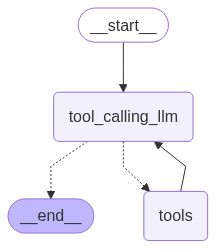

In [19]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
graph_with_memory = graph.compile(checkpointer=memory)
display(Image(graph_with_memory.get_graph().draw_mermaid_png()))


In [21]:
## Specify the thread. You need to specify a unique thread id for each thread. 
# You can have one thread for each user.
config={"configurable": {"thread_id": "1"}}

messages = graph_with_memory.invoke({"messages": HumanMessage(content="Add 5 plus 5 and then multiply 10")}, config=config)

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

Add 5 plus 5 and then multiply 10
================================== Ai Message ==================================
Tool Calls:
  add (call_RB4TQ1yBb0IqBMGqRphKF0eK)
 Call ID: call_RB4TQ1yBb0IqBMGqRphKF0eK
  Args:
    a: 5
    b: 5
  multiply (call_eV1Laa8OKYLe9wQkM7vGFqqL)
 Call ID: call_eV1Laa8OKYLe9wQkM7vGFqqL
  Args:
    a: 10
    b: 10
================================= Tool Message =================================
Name: add

10
================================= Tool Message =================================
Name: multiply

100
================================== Ai Message ==================================

The sum of 5 and 5 is 10, and when you multiply 10 by 10, you get 100.


In [22]:
messages = graph_with_memory.invoke({"messages": HumanMessage(content="Add that number to 25")}, config=config)

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

Add 5 plus 5 and then multiply 10
================================== Ai Message ==================================
Tool Calls:
  add (call_RB4TQ1yBb0IqBMGqRphKF0eK)
 Call ID: call_RB4TQ1yBb0IqBMGqRphKF0eK
  Args:
    a: 5
    b: 5
  multiply (call_eV1Laa8OKYLe9wQkM7vGFqqL)
 Call ID: call_eV1Laa8OKYLe9wQkM7vGFqqL
  Args:
    a: 10
    b: 10
================================= Tool Message =================================
Name: add

10
================================= Tool Message =================================
Name: multiply

100
================================== Ai Message ==================================

The sum of 5 and 5 is 10, and when you multiply 10 by 10, you get 100.
================================ Human Message =================================

Add that number to 25
================================== Ai Message ==================================
Tool Calls:
  add (call_TU7mTkFyHUvqMlqIV3

### Streaming

Methods: .stream() and astream()
- These methods are sync and async methods for streaming back results.

Additional parameters in streaming modes for graph state
- Values: This streams the full state of the graph after each node is called.
- Updates: This streams updates to the state of the graph after each node is called.

In [2]:
config={"configurable": {"thread_id": "2"}}

for chunk in graph_builder.stream({"messages": HumanMessage(content="Add 5 plus 5 and then multiply 10")}, config=config, stream="updates"):
    chunk.pretty_print()

NameError: name 'graph_builder' is not defined